In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('hanoi_quality.csv')
df1=df.reset_index()['pm25']

In [3]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    data_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    data_smoothed_interpolated = data_smoothed.interpolate()

    # Fill remaining NaN values
    data_smoothed_filled = data_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)

    return data_smoothed_filled

In [4]:
df1= smoothed(df1)
print(df1)

0       64.6
1       64.6
2       64.6
3       64.6
4       64.6
        ... 
1915    62.4
1916    54.2
1917    55.8
1918    59.4
1919    67.2
Name: pm25, Length: 1920, dtype: float64


In [5]:
df1.shape

(1920,)

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [8]:
print(train_size)
print(test_size)

1536
384


In [9]:
print(train_data.shape)
print(test_data.shape)


(1536, 1)
(384, 1)


In [10]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1435, 100)
(1435,)
(283, 100)
(283,)


In [13]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [14]:
print(X_train.shape)
print(X_test.shape)

(1435, 100, 1)
(283, 100, 1)


In [15]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0112
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0020
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0015
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0014
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0012
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - l

In [17]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [18]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [19]:
y_pred = pd.DataFrame(y_pred, columns=['pm25'])
y_pred = smoothed(y_pred)
y_pred = y_pred.to_numpy()

In [20]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 52.561295940998406
Testing MAPE: 62.204786756505506
Testing MAE: 48.51340492367745


In [21]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 324)

In [22]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 324)
[0.33779883]
325
1 day input [0.2609209  0.29752066 0.37190083 0.4025974  0.4120425  0.42739079
 0.4214876  0.35419126 0.29634002 0.27508855 0.22550177 0.20306966
 0.23612751 0.27272727 0.31404959 0.35182999 0.35773318 0.33293979
 0.3364817  0.31404959 0.28099174 0.27154664 0.25737898 0.23730815
 0.23140496 0.2609209  0.2892562  0.34946871 0.37662338 0.4025974
 0.38606848 0.364817   0.34828808 0.36363636 0.34946871 0.39433294
 0.3931523  0.37780401 0.35064935 0.35891381 0.31995277 0.3459268
 0.32585596 0.33530106 0.30578512 0.30932704 0.27863046 0.32349469
 0.36245573 0.43211334 0.45454545 0.43565525 0.39905549 0.39197166
 0.37780401 0.35182999 0.39079103 0.43919717 0.42975207 0.4309327
 0.4120425  0.36599764 0.31050767 0.29515939 0.27744982 0.30342385
 0.32585596 0.30224321 0.25265643 0.20188902 0.16883117 0.17827627
 0.24321133 0.29279811 0.29161747 0.2987013  0.32585596 0.34828808
 0.34002361 0.39079103 0.44746163 0.45808737 0.41794569 0.41440378
 0.39433294 0.33530106 0.30

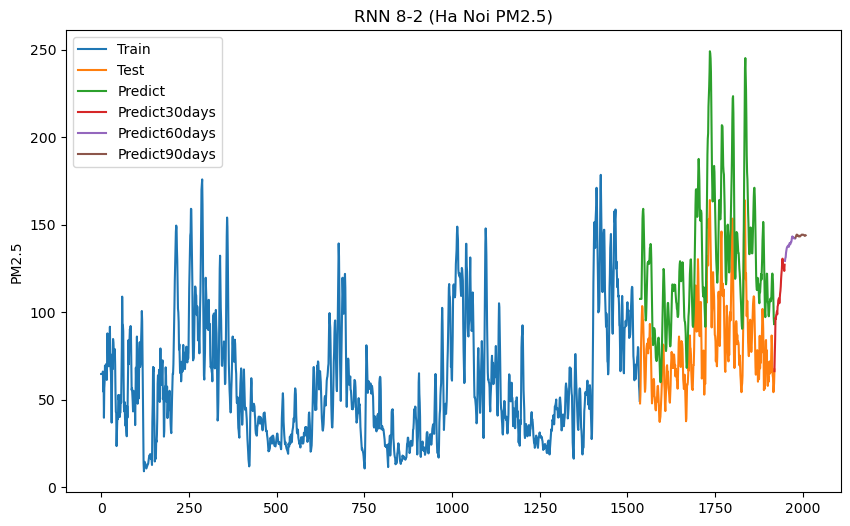

In [23]:
# Define the indices
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot train data
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot test data and predictions
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred, label='Predict')

# Plot predictions for future data in 30-day intervals
for i in range(3):
    start_idx = len(df1) + (i * 30) - 1
    end_idx = start_idx + 30
    plt.plot(pd.RangeIndex(start=start_idx, stop=end_idx, step=1),
             scaler.inverse_transform(lst_output[i*30:(i+1)*30]),
             label=f'Predict{i*30+30}days')

# Add legend and labels
plt.legend()
plt.title('RNN 8-2 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

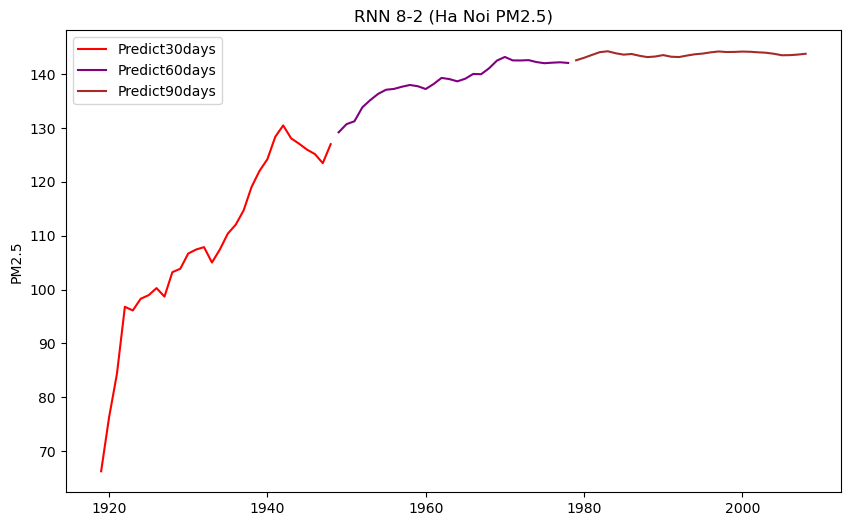

In [24]:
plt.figure(figsize=(10, 6))

# Plot predictions for future data in 30-day intervals with specified colors
colors = ['red', 'purple', 'brown']
for i in range(3):
    start_idx = len(df1) + (i * 30) - 1
    end_idx = start_idx + 30
    plt.plot(pd.RangeIndex(start=start_idx, stop=end_idx, step=1),
             scaler.inverse_transform(lst_output[i*30:(i+1)*30]),
             label=f'Predict{i*30+30}days',
             color=colors[i])

# Add legend and labels
plt.legend()
plt.title('RNN 8-2 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()